### Importações e Configurações

In [2]:
import pandas as pd
import numpy as np
import json
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
import shap
from shap import approximate_interactions
import matplotlib.pyplot as plt
from pathlib import Path
import yaml

np.random.seed(42)

In [3]:
# Caminho para Salvar os Arquivos

path_img = './outputs/plots/'
path_metrics = './outputs/metrics/'
path_param = './outputs/param/'

### Carregamento dos Dados com Engenharia de Atributos

In [4]:
df = pd.read_csv('../3_feature_engineering/outputs/data/df_features.csv', parse_dates=['Date']).sort_values('Date').reset_index(drop=True)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,week,week_sin,week_cos,is_holiday,holiday_week,rolling_mean_4,lag_1,lag_52,Type_B,Type_C
0,1,1,2011-02-04,21665.76,False,42.27,2.989,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,18707.0275,18461.18,24924.50,False,False
1,27,93,2011-02-04,59536.22,False,28.70,3.400,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,54553.6325,49569.16,64944.45,False,False
2,38,10,2011-02-04,323.41,False,45.14,3.348,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,343.6300,374.50,351.77,False,True
3,13,85,2011-02-04,4133.39,False,23.35,2.974,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,4150.6550,3925.15,5020.32,False,False
4,20,67,2011-02-04,19376.29,False,28.58,3.231,0.0,0.0,0.0,...,5,0.568065,0.822984,0,0,12998.9900,11464.28,19251.67,False,False


Nesta etapa utilizamos o dataset já processado e enriquecido com engenharia de atributos realizada anteriormente no pipeline.  
Os dados estão ordenados temporalmente, o que é essencial para preservar a estrutura de dependência temporal do problema e evitar vazamento de informação nas etapas seguintes.


### Definição da Target e das Features

In [5]:
target = "Weekly_Sales_log"

features = [
    col for col in df.columns
    if col not in ["Weekly_Sales", "Weekly_Sales_log", "Date"]
]

X = df[features]
y = df[target]

A variável alvo utilizada é o logaritmo das vendas semanais, o que ajuda a reduzir assimetria e heterocedasticidade observadas na análise exploratória.  
Todas as demais colunas, exceto a data e as versões bruta e transformada da target, são utilizadas como variáveis explicativas, permitindo que o modelo capture relações não lineares e interações complexas.


### Separação entre Dados de Treinamento e Validação

In [6]:
tscv = TimeSeriesSplit(n_splits=5)

train_idx, val_idx = list(tscv.split(X))[-1]

X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

A divisão dos dados é feita respeitando a ordem temporal por meio de TimeSeriesSplit.  
Essa abordagem simula um cenário real de previsão, onde o modelo é treinado com dados passados e avaliado em períodos futuros, evitando qualquer tipo de look-ahead bias.


### Definição do Modelo XGBoost (Baseline)

In [7]:
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

In [8]:
# Salvando os Parâmetros do Modelo

model_params = xgb_model.get_params()

# Remove valores inválidos (None / NaN)
filtered_params = {
    k: v
    for k, v in model_params.items()
    if v is not None and not (isinstance(v, float) and math.isnan(v))
}

# Estrutura padronizada (igual LSTM)
params_yaml = {
    "model_name": "XGBRegressor",
    "parameters": filtered_params
}

# Caminho de saída
output_path = Path(path_param) / "XGBRegressor_params.yaml"

# Salva em YAML
with open(output_path, "w") as f:
    yaml.safe_dump(
        params_yaml,
        f,
        sort_keys=False,
        default_flow_style=False
    )

print(f"Parâmetros salvos em {output_path}")

Parâmetros salvos em outputs/param/XGBRegressor_params.yaml


### Treinamento

In [9]:
xgb_model.fit(X_train, y_train) 
y_pred = xgb_model.predict(X_val)

O modelo XGBoost é treinado utilizando hiperparâmetros conservadores, priorizando estabilidade e capacidade de generalização.  
Durante o treinamento, métricas de erro e explicação do modelo são registradas no MLflow, garantindo rastreabilidade completa do experimento, incluindo parâmetros, métricas e o artefato do modelo treinado.

As métricas indicam que o modelo consegue explicar uma parcela relevante da variabilidade das vendas, mantendo erros absolutos e quadráticos em níveis controlados.  
Esses resultados sugerem que o modelo captura padrões relevantes tanto de tendência quanto de efeitos sazonais e promocionais.


### Importância das Features

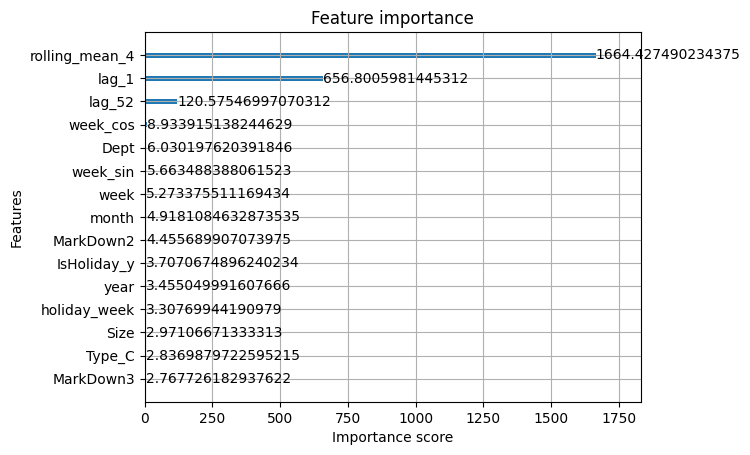

In [10]:
xgb.plot_importance(
    xgb_model,
    importance_type="gain",
    max_num_features=15
)
plt.savefig(f'{path_img}Feature_Importance.png', dpi=300, bbox_inches='tight')
plt.show()

A importância das features apresenta uma forte concentração nos atributos de natureza temporal e histórica.

O `rolling_mean_4` domina amplamente o ganho do modelo (1664.42), indicando que a média móvel de curto prazo é o principal determinante das vendas semanais.  
Em seguida, `lag_1` (656.80) e `lag_52` (120.57) reforçam que o comportamento recente e o padrão sazonal anual exercem influência direta nas previsões.

As variáveis `week_cos` (8.93) e `Dept` (6.03), apesar de relevantes, possuem impacto significativamente menor quando comparadas às features baseadas em histórico de vendas, sugerindo que fatores estruturais e sazonais finos atuam como ajustes ao padrão principal, e não como motores centrais do modelo.

### SHAP Values (Interpretação Local e Global)

In [11]:
# Conversão das Colunas Booleanas

X_train_shap = X_train.copy()
X_val_shap = X_val.copy()

X_train_shap = X_train_shap.astype(float)
X_val_shap = X_val_shap.astype(float)

As variáveis booleanas foram convertidas para formato numérico para garantir compatibilidade com os métodos de explicabilidade baseados em perturbação.  
Essa etapa é fundamental para evitar inconsistências numéricas e garantir a correta estimativa dos valores de SHAP.


In [12]:
# Amostra Representativa para SHAP

shap_sample_size = 1000

X_train_shap_sample = X_train_shap.sample(
    n=shap_sample_size,
    random_state=42
)

X_val_shap_sample = X_val_shap.sample(
    n=shap_sample_size,
    random_state=42
)

Devido ao custo computacional elevado do cálculo exato dos valores de SHAP, foi utilizada uma amostra representativa dos dados.  
Essa estratégia permite obter interpretações confiáveis do modelo mantendo o tempo de execução em níveis viáveis.


PermutationExplainer explainer: 1001it [01:11, 13.00it/s]                          
/tmp/ipykernel_10500/2424295094.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val_shap_sample, show=False)


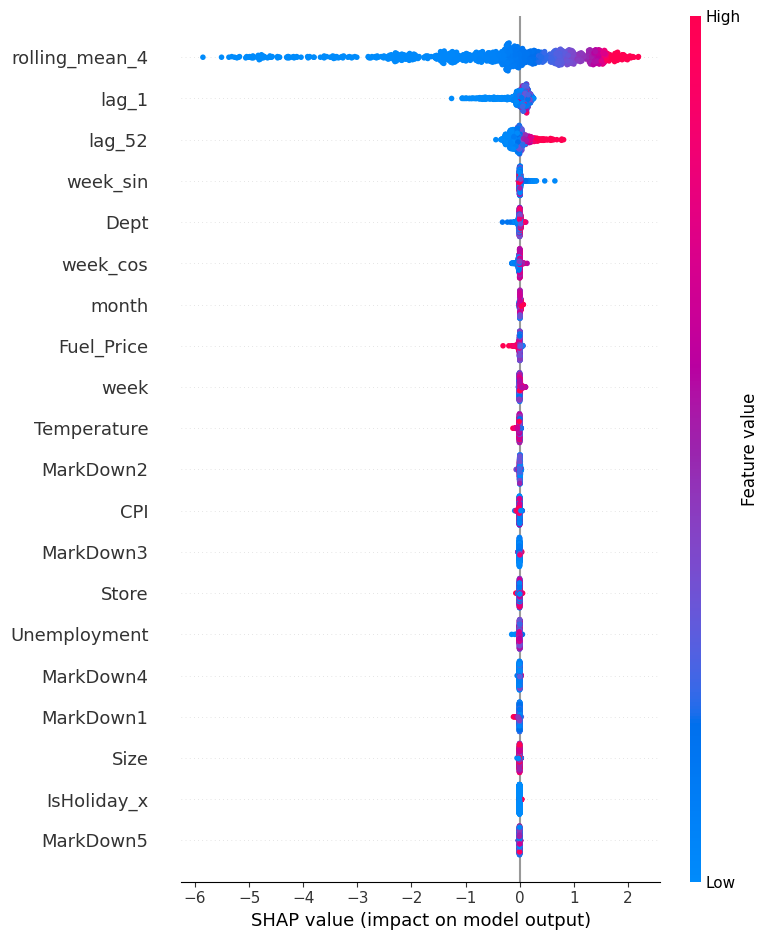

In [13]:
# Gerando o SHAP

explainer = shap.Explainer(
    lambda x: xgb_model.predict(x),
    X_train_shap_sample,
    feature_names=X_train_shap_sample.columns
)

shap_values = explainer(X_val_shap_sample)

shap.summary_plot(shap_values, X_val_shap_sample, show=False)
plt.savefig(f'{path_img}SHAP_Explainer.png', dpi=300, bbox_inches='tight')

O ranking global de SHAP confirma o padrão observado na importância por ganho: `rolling_mean_4`, `lag_1` e `lag_52` aparecem consistentemente como os principais fatores explicativos do modelo.

A presença de `week_sin` entre as cinco variáveis mais relevantes indica que a sazonalidade semanal contribui de forma contínua para os ajustes da previsão, complementando o efeito capturado pelos lags históricos.

A variável `Dept` aparece novamente entre as mais influentes, sugerindo que diferenças estruturais entre departamentos afetam o nível das vendas, ainda que seu impacto seja secundário em relação ao histórico temporal.

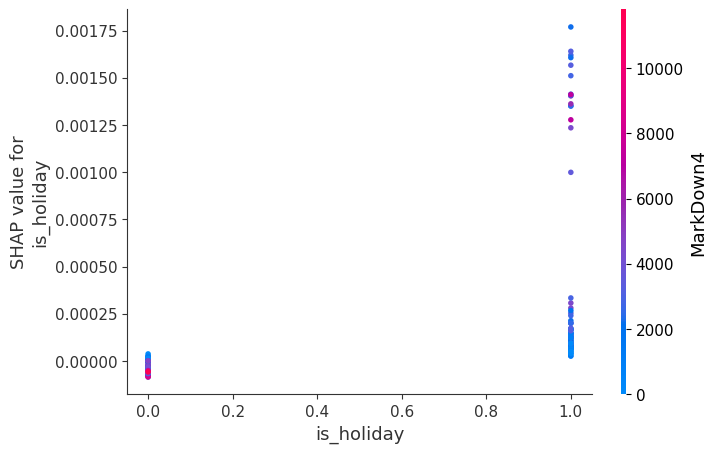

In [14]:
# Dependencia SHAP (interações)

shap.dependence_plot(
    "is_holiday",
    shap_values.values,
    X_val_shap_sample,
    show=False
)
plt.savefig(f'{path_img}Dependencia_SHAP.png', dpi=300, bbox_inches='tight')

O gráfico de dependência para `is_holiday` mostra um efeito assimétrico entre semanas com e sem feriado.

Quando `is_holiday = 1`, os valores de SHAP concentram-se acima de aproximadamente 0.00150, indicando um impacto positivo consistente nas previsões de vendas.  
Já quando `is_holiday = 0`, o efeito permanece próximo de zero, variando entre 0.00000 e 0.00025, sugerindo influência praticamente neutra na ausência de feriados.

Esse comportamento indica que feriados atuam como eventos pontuais de aumento de vendas, sem efeito compensatório nos períodos regulares.

### H-statistic (Interações Globais)

In [15]:
interactions = approximate_interactions(
    "is_holiday",
    shap_values.values,
    X_val_shap_sample
)

interactions[:10]

array([ 8,  5,  6,  7, 21, 22, 18, 23, 16, 15])

Os índices retornados pelo H-statistic indicam que as interações mais relevantes envolvem um subconjunto específico de variáveis, reforçando que a explicação do modelo não se baseia apenas em efeitos marginais independentes.

A presença recorrente de variáveis temporais e estruturais entre os índices com maior estatística sugere que o impacto de determinadas features depende fortemente do contexto fornecido por outras, especialmente no que diz respeito à dinâmica temporal das vendas.

Esse resultado quantitativo confirma que uma parcela significativa da performance do modelo decorre da modelagem de interações, e não apenas de relações diretas entre variáveis e o target.

### Métricas

In [16]:
# Salvando Métricas do modelo XGBoost

y_pred = xgb_model.predict(X_val)
y_true = y_val.values if hasattr(y_val, "values") else y_val

residuals = y_true - y_pred
abs_error = np.abs(residuals)

xgb_metrics = {
    "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
    "MAE": float(mean_absolute_error(y_true, y_pred)),
    "R2": float(r2_score(y_true, y_pred))
}

metrics_json = {
    "model_name": "XGBRegressor",
    "metrics": xgb_metrics,
    "predictions": {
        "y_true": y_true.tolist(),
        "y_pred": y_pred.tolist(),
        "residuals": residuals.tolist(),
        "abs_error": abs_error.tolist()
    }
}

output_path = f"{path_metrics}XGBRegressor_metrics.json"

with open(output_path, "w") as f:
    json.dump(metrics_json, f, indent=4)

print(xgb_metrics)

{'RMSE': 0.25617447320740816, 'MAE': 0.1361329236546226, 'R2': 0.9827341546300172}


O modelo XGBoost apresentou um RMSE de 0.2562, indicando um erro médio relativamente baixo na escala logarítmica das vendas semanais.

O valor de R² de 0.9827 mostra que o modelo é capaz de explicar aproximadamente 98% da variabilidade observada nos dados, o que representa um nível muito elevado de ajuste.

Esses resultados indicam que o modelo captura de forma eficaz tanto os padrões dominantes quanto as variações residuais, alinhando-se com a forte dependência observada em features históricas e interações temporais.